In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import utils

pd.options.mode.chained_assignment = None
plt.rcParams['figure.figsize'] = (6, 8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
conn = utils.load_connection()

In [4]:
if os.path.exists('all_clicks.csv.gz'):
    df_all_clicks = pd.read_csv('all_clicks.csv.gz', compression='gzip')
    df_all_clicks['click_time'] = pd.to_datetime(df_all_clicks['click_time'])
else:
    clicks_sql = '''
    select *
    from public.bertly_clicks
    where user_agent is not null
    and northstar_id is not null
    '''
    df_all_clicks = pd.read_sql(clicks_sql, con=conn)
    df_all_clicks.to_csv('all_clicks.csv.gz', compression='gzip', index=False)

In [5]:
#  known user agents to filter on
samsung_preview_ua = 'Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:24.0) Gecko/20100101 Firefox/24.0'
samsung_unknown_ua = 'Apache-HttpClient/UNAVAILABLE (java 1.4)'
ios_preview_ua = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1) AppleWebKit/601.2.4 (KHTML, like Gecko) Version/9.0.1 Safari/601.2.4 facebookexternalhit/1.1 Facebot Twitterbot/1.0'


In [6]:
#  known bots
bots = list(df_all_clicks[
    df_all_clicks['user_agent'].str.contains('bot') & (df_all_clicks['user_agent'] != ios_preview_ua)]['user_agent'].unique()) + [
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2623.75 Safari/537.36 Google Favicon',
    'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36 Google (+https://developers.google.com/+/web/snippet/)',
]

### Breakdown of interaction by activity type

In [7]:
df_all_clicks.loc[df_all_clicks['user_agent'] == samsung_preview_ua, 'ua_bucket'] = 'preview_android'
df_all_clicks.loc[df_all_clicks['user_agent'] == ios_preview_ua, 'ua_bucket'] = 'preview_ios'
df_all_clicks.loc[df_all_clicks['user_agent'] == samsung_unknown_ua, 'ua_bucket'] = 'unclassified'
df_all_clicks.loc[df_all_clicks['user_agent'].isin(bots), 'ua_bucket'] = 'unclassified_bots'
df_all_clicks.loc[df_all_clicks['user_agent'].str.contains('iphone', case=False), 'ua_bucket'] = 'click_ios'
df_all_clicks.loc[df_all_clicks['user_agent'].str.contains('android', case=False), 'ua_bucket'] = 'click_android'
df_all_clicks.loc[df_all_clicks['ua_bucket'].isnull(), 'ua_bucket'] = 'unclassified'

In [8]:
df_clicks_byua_month = df_all_clicks.set_index('click_time').groupby(
    ['ua_bucket', pd.Grouper(freq='M')])['northstar_id'].count().sort_values(ascending=False).reset_index()

In [9]:
df_clicks_byua_month.head()

,ua_bucket,click_time,northstar_id
0,preview_android,2018-08-31,330988
1,preview_android,2018-09-30,319457
2,preview_android,2018-10-31,211610
3,unclassified,2018-10-31,159742
4,click_ios,2018-09-30,80816


In [10]:
df_clicks_byua_month = df_clicks_byua_month.pivot(
    index='ua_bucket', columns='click_time', values='northstar_id').fillna(0)

In [11]:
df_clicks_byua_month

click_time,2018-08-31 00:00:00,2018-09-30 00:00:00,2018-10-31 00:00:00
ua_bucket,,,
click_android,25911,20981,13645
click_ios,80787,80816,53760
preview_android,330988,319457,211610
preview_ios,42606,28639,12695
unclassified,62709,70343,159742
unclassified_bots,6080,7094,4898


In [12]:
df_clicks_byua_month / df_clicks_byua_month.sum(axis=0)

click_time,2018-08-31 00:00:00,2018-09-30 00:00:00,2018-10-31 00:00:00
ua_bucket,,,
click_android,0.047190,0.039787,0.029900
click_ios,0.147131,0.153255,0.117804
preview_android,0.602804,0.605801,0.463701
preview_ios,0.077595,0.054309,0.027819
unclassified,0.114207,0.133395,0.350043
unclassified_bots,0.011073,0.013453,0.010733


### Define autogenerated vs. tap-to-load previews.
Group by northstar_id and broadcast_id to look at groups of interactions and code previews within each group according to below heuristics:

A. Consider tap-to-load if...
    1. The group has 1 record, and it's a preview.
    2. The group has 2 records: both previews from either os.
    3. The group has 2 records: 1 preview, 1 click (from either os).
    4. The group has > 2 records: 1 preview, 2+ clicks (from either os).
B. Consider autogenerated if...
    1. The group has more than 1 preview.

In [13]:
df_all_clicks = df_all_clicks.sort_values(['northstar_id', 'broadcast_id', 'click_time'])

In [14]:
# find boundaries to define groups where northstar_id or broadcast_id change
df_all_clicks['group'] = ((
    (df_all_clicks[['northstar_id', 'broadcast_id']].shift(1) == df_all_clicks[['northstar_id', 'broadcast_id']]).sum(
        axis=1)) < 2).astype(int)

In [15]:
df_all_clicks['group'] = df_all_clicks['group'].cumsum()

In [16]:
if os.path.exists('final_grouped.csv.gz'):
    df_all_clicks_grouped = pd.read_csv('final_grouped.csv.gz', compression='gzip')
    df_all_clicks_grouped.rename(columns={'Unnamed: 0': 'group'}, inplace=True)
else:
    df_all_clicks_grouped = df_all_clicks.groupby('group').agg({
        'ua_bucket':  {'unique_uas': lambda x: str(x.unique()), 'num_previews': utils.num_previews},
        'northstar_id': 'count',
    }).reset_index()
    df_all_clicks_grouped.columns = df_all_clicks_grouped.columns.droplevel(0)

    df_all_clicks_grouped.to_csv('final_grouped.csv.gz', index=False, compression='gzip')
    df_all_clicks_grouped.rename(columns={'Unnamed: 0': 'group'}, inplace=True)

In [17]:
df_all_clicks_grouped['contains_preview'] = df_all_clicks_grouped['unique_uas'].apply(utils.contains_preview)
df_all_clicks_grouped['contains_click'] = df_all_clicks_grouped['unique_uas'].apply(utils.contains_click)
df_all_clicks_grouped['contains_multiple_os'] = df_all_clicks_grouped['unique_uas'].apply(utils.contains_multiple_os)

In [18]:
# create clicks groups
click_groups = df_all_clicks_grouped[
    (df_all_clicks_grouped['count'] > 1) & 
    (df_all_clicks_grouped['contains_click'] == 1) &
    (df_all_clicks_grouped['contains_multiple_os'] == 0) &
    (df_all_clicks_grouped['contains_preview'] == 0)
]['group']

df_all_clicks.loc[(df_all_clicks['ua_bucket'].str.contains('click')) & 
                  (df_all_clicks['group'].isin(list(click_groups))), 
                  'preview_bucket'] = 'click'

In [19]:
# create group A1
preview_tap_groups = df_all_clicks_grouped[
    (df_all_clicks_grouped['count'] == 1) & (df_all_clicks_grouped['contains_preview'] == 1)]['group']

df_all_clicks.loc[(df_all_clicks['ua_bucket'].str.contains('preview')) & 
                  (df_all_clicks['group'].isin(list(preview_tap_groups))), 
                  'preview_bucket'] = 'tap-to-load'

In [20]:
# create group A2
preview_multipleos_tap_groups = df_all_clicks_grouped[
    (df_all_clicks_grouped['count'] == 2) & 
    (df_all_clicks_grouped['contains_preview'] == 1) &
    (df_all_clicks_grouped['contains_click'] == 0) &
    (df_all_clicks_grouped['contains_multiple_os'] == 1)
]['group']

df_all_clicks.loc[(df_all_clicks['ua_bucket'].str.contains('preview')) & 
                  (df_all_clicks['group'].isin(list(preview_multipleos_tap_groups))), 
                  'preview_bucket'] = 'tap-to-load'

In [21]:
# create group A3
previewclick_tap_groups = df_all_clicks_grouped[
    (df_all_clicks_grouped['count'] == 2) & 
    (df_all_clicks_grouped['contains_preview'] == 1) & 
    (df_all_clicks_grouped['contains_click'] == 1) &
    (df_all_clicks_grouped['contains_multiple_os'] != 2)
]['group']

df_all_clicks.loc[(df_all_clicks['ua_bucket'].str.contains('preview')) & 
                  (df_all_clicks['group'].isin(list(previewclick_tap_groups))), 
                  'preview_bucket'] = 'tap-to-load'

df_all_clicks.loc[(df_all_clicks['ua_bucket'].str.contains('click')) & 
                  (df_all_clicks['group'].isin(list(previewclick_tap_groups))), 
                  'preview_bucket'] = 'click'

In [22]:
# create group A4
previewclick_mult_tap_groups = df_all_clicks_grouped[
    (df_all_clicks_grouped['count'] > 2) & 
    (df_all_clicks_grouped['contains_preview'] == 1) & 
    (df_all_clicks_grouped['contains_click'] == 1) &
    (df_all_clicks_grouped['contains_multiple_os'] != 2) &
    (df_all_clicks_grouped['num_previews'] == 1)
]['group']

df_all_clicks.loc[(df_all_clicks['ua_bucket'].str.contains('preview')) & 
                  (df_all_clicks['group'].isin(previewclick_mult_tap_groups)),
                  'preview_bucket'] = 'tap-to-load'

df_all_clicks.loc[(df_all_clicks['ua_bucket'].str.contains('click')) & 
                  (df_all_clicks['group'].isin(previewclick_mult_tap_groups)),
                  'preview_bucket'] = 'click'

In [23]:
# labels remaining cases of previews as 'autogenerated'
df_all_clicks.loc[(df_all_clicks['ua_bucket'].str.contains('preview')) & 
                  (df_all_clicks['preview_bucket'].isnull()),
                  'preview_bucket'] = 'autogenerated'

<b> Clicks by activity type </b>

In [24]:
# grab september from clicks by activity type
df_clicks_byactivity_sept = (df_clicks_byua_month / df_clicks_byua_month.sum(axis=0)).iloc[:, 1]

In [25]:
df_clicks_byactivity_sept 

ua_bucket
click_android        0.039787
click_ios            0.153255
preview_android      0.605801
preview_ios          0.054309
unclassified         0.133395
unclassified_bots    0.013453
Name: 2018-09-30 00:00:00, dtype: float64

<b> Clicks by preview type </b>

In [26]:
df_clicks_bypreview_mo = df_all_clicks.set_index('click_time').groupby(
    ['ua_bucket', 'preview_bucket', pd.Grouper(freq='m')])['northstar_id'].count().unstack()

In [27]:
df_clicks_bypreview_mo

click_time                      2018-08-31  2018-09-30  2018-10-31
ua_bucket       preview_bucket                                    
click_android   click                 7829        5669        3503
click_ios       click                23587       12726        7610
preview_android autogenerated       282216      270677      162676
                tap-to-load          48772       48780       48934
preview_ios     autogenerated         2427        1495         745
                tap-to-load          40179       27144       11950

In [28]:
# grab september column and reshape 
df_clicks_bypreview_sept = df_clicks_bypreview_mo.iloc[:, 1].unstack(1).iloc[2:]

In [29]:
df_clicks_bypreview_sept['total'] = df_clicks_bypreview_sept.sum(axis=1)

In [30]:
df_clicks_bypreview_sept = (df_clicks_bypreview_sept).divide(df_clicks_bypreview_sept['total'], axis=0)

In [31]:
df_clicks_bypreview_sept.drop(['total'], axis=1, inplace=True)

In [32]:
df_clicks_bypreview_sept = df_clicks_bypreview_sept.stack()
df_clicks_bypreview_sept

ua_bucket        preview_bucket
preview_android  autogenerated     0.847303
                 tap-to-load       0.152697
preview_ios      autogenerated     0.052202
                 tap-to-load       0.947798
dtype: float64

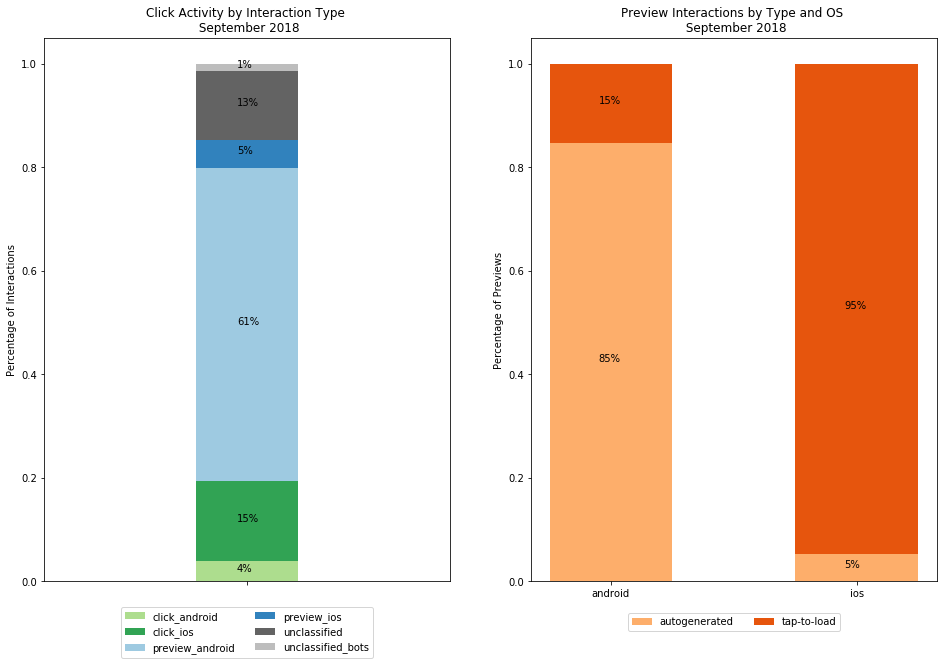

In [65]:
clicks_color_dict = {
    'click_ios': '#31a354',
    'click_android': '#addd8e',
    'preview_ios': '#3182bd',
    'preview_android': '#9ecae1',
    'unclassified_bots': '#bdbdbd',
    'unclassified': '#636363',
}

previewtype_color_dict = {
    'autogenerated': '#fdae6b',
    'tap-to-load': '#e6550d',
}

fig, (ax1, ax2) = plt.subplots(1, 2)
utils.plot_interactions_stacked_bar(
    df_clicks_byactivity_sept,
    ax=ax1,
    color_dict=clicks_color_dict,
    title='Click Activity by Interaction Type \n September 2018')
utils.plot_previews_stacked_bar(
    df_clicks_bypreview_sept,
    ax=ax2,
    color_dict=previewtype_color_dict,
    title='Preview Interactions by Type and OS \n September 2018'
)
fig.set_size_inches(16, 10)
fig.savefig('click_activity_breakdown.png', format='png', dpi=1000)

### Breakdown of unique members by activity type
Click [broken down by OS]: At least 1 click that month and in one of the above defined groups.    
Preview [broken down by OS]: No clicks, only previews of any type.    
Other: Can't determine from UA.

In [34]:
df_preview_activity_bymo = df_all_clicks.set_index('click_time').groupby(['northstar_id', pd.Grouper(freq='M')]).agg({
    'preview_bucket': {'activity_bucket': utils.user_monthly_activity, 'preview_bucket': utils.user_preview_activity},
    'ua_bucket': utils.return_os,
}).reset_index()

/usr/local/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [35]:
df_preview_activity_bymo.columns = ['northstar_id', 'click_time', 'activity_bucket', 'preview_bucket', 'os']

In [36]:
df_preview_activity_bymo.head()

,northstar_id,click_time,activity_bucket,preview_bucket,os
0,340749,2018-09-30,preview,tap-to-load,ios
1,54fa272d469c64d7068b4577,2018-09-30,preview,tap-to-load,ios
2,54fa2731469c64d8068b458e,2018-08-31,unclassified/bot,None,unclassified/bot
3,54fa2731469c64d8068b458e,2018-09-30,unclassified/bot,None,unclassified/bot
4,54fa2732469c64d7068b4595,2018-08-31,unclassified/bot,None,ios


In [37]:
df_mam_activity_bymo = df_preview_activity_bymo.groupby(
    ['activity_bucket', 'os', 'click_time'])['northstar_id'].count().unstack()

In [38]:
df_mam_activity_sept = df_mam_activity_bymo.iloc[:, 1]

In [39]:
df_mam_activity_sept

activity_bucket   os              
click             android              1998
                  ios                 11201
preview           android             69346
                  ios                 14394
unclassified/bot  android              8789
                  ios                 11848
                  unclassified/bot    22417
Name: 2018-09-30 00:00:00, dtype: int64

In [40]:
df_mam_activity_sept_percent = df_mam_activity_sept / df_mam_activity_sept.sum()

In [41]:
labels = df_mam_activity_sept_percent.reset_index().apply(utils.create_label, axis=1)

In [42]:
df_mam_activity_sept_percent = pd.DataFrame({'percent': df_mam_activity_sept_percent.values}, index=labels)

In [43]:
df_mam_activity_sept_percent

,percent
click_android,0.014272
click_ios,0.080011
preview_android,0.495353
preview_ios,0.102819
unclassified/bot,0.062782
unclassified/bot,0.084633
unclassified/bot,0.160129


### Breakdown of unique members by preview type

In [44]:
df_mam_by_preview_sept = df_preview_activity_bymo[df_preview_activity_bymo['activity_bucket'] == 'preview'].groupby(
    ['preview_bucket', 'os', 'click_time'])['northstar_id'].count().unstack().iloc[:, 1]

In [45]:
df_mam_by_preview_sept = df_mam_by_preview_sept.unstack(0)

In [46]:
df_mam_by_preview_sept['total'] = df_mam_by_preview_sept.sum(axis=1)

In [47]:
df_mam_by_preview_sept_percent = (df_mam_by_preview_sept).divide(df_mam_by_preview_sept['total'], axis=0)

In [48]:
df_mam_by_preview_sept_percent.drop(['total'], axis=1, inplace=True)

In [49]:
df_mam_by_preview_sept_percent = df_mam_by_preview_sept_percent.stack()

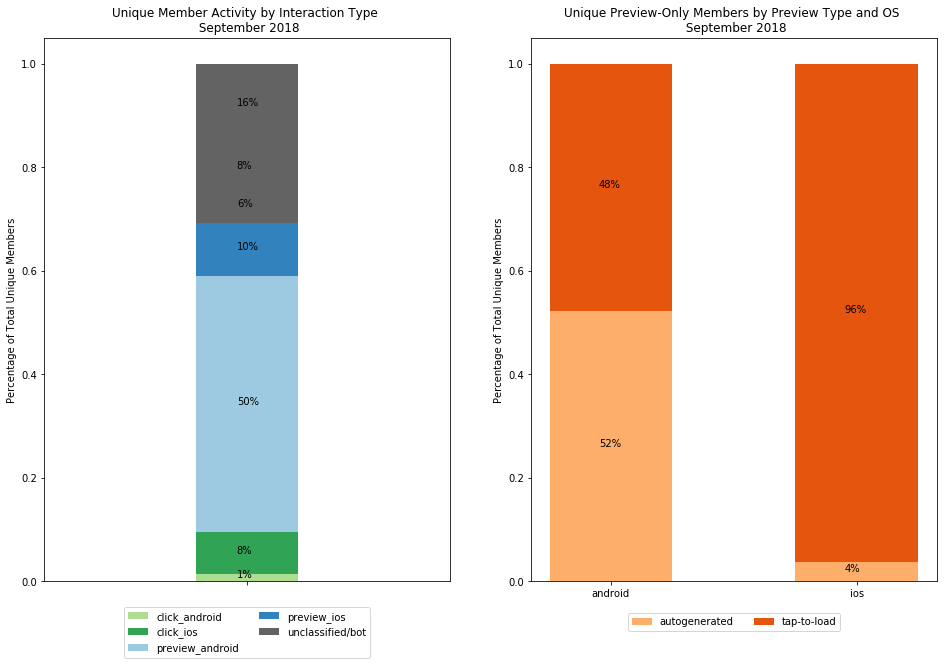

In [50]:
previews_color_dict = {
    'click_ios': '#31a354',
    'click_android': '#addd8e',
    'preview_ios': '#3182bd',
    'preview_android': '#9ecae1',
    'unclassified/bot': '#636363',
}

fig, (ax1, ax2) = plt.subplots(1, 2)
utils.plot_interactions_stacked_bar(
    df_mam_activity_sept_percent['percent'], 
    ax=ax1,
    color_dict=previews_color_dict, 
    title='Unique Member Activity by Interaction Type \n September 2018',
    ylabel='Percentage of Total Unique Members'
)
utils.plot_previews_stacked_bar(
    df_mam_by_preview_sept_percent,
    ax=ax2,
    color_dict=previewtype_color_dict,
    title='Unique Preview-Only Members by Preview Type and OS \n September 2018',
    ylabel='Percentage of Total Unique Members'
)
fig.set_size_inches(16, 10)

### Count of Unique Members 

In [51]:
total_num_members = df_mam_activity_sept.sum()

In [52]:
num_autogen_members = df_mam_by_preview_sept['autogenerated'].sum()

In [53]:
df_num_unique_members_sept = df_mam_activity_sept.reset_index()
df_num_unique_members_sept.columns = ['activity_bucket', 'os', 'num_members']
num_no_preview_members = df_num_unique_members_sept[~(
    df_num_unique_members_sept['activity_bucket'] == 'preview')]['num_members'].sum()

In [54]:
num_members_estimate = total_num_members - num_autogen_members

In [55]:
print(total_num_members, num_members_estimate, num_no_preview_members)

139993 103293 56253


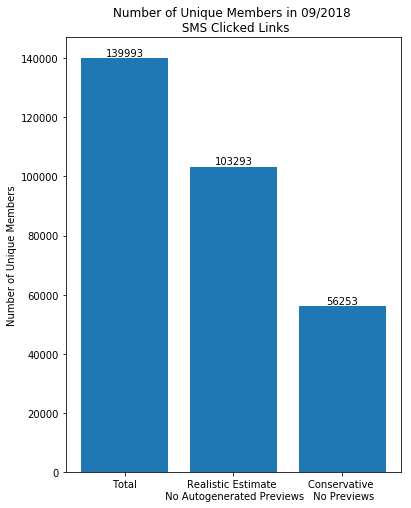

In [56]:
bars = plt.bar(x=[0, 1, 2], height=[total_num_members, num_members_estimate, num_no_preview_members])
plt.xticks(ticks=[0, 1, 2], labels=[
    'Total', 'Realistic Estimate \n No Autogenerated Previews', 'Conservative \n No Previews'])
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')
plt.ylabel('Number of Unique Members')
plt.title('Number of Unique Members in 09/2018 \n SMS Clicked Links');

### Count of unique members pulling in all interaction types

In [57]:
member_activity_sept_sql = '''
select *
from public.member_event_log
where timestamp between '2018-09-01' and '2018-10-01'
'''
df_member_activity_sept = pd.read_sql(member_activity_sept_sql, con=conn)

In [58]:
num_members_allactivity = len(df_member_activity_sept['northstar_id'].unique())

In [59]:
df_member_activity_sept_nobertly = df_member_activity_sept[~(
    df_member_activity_sept['action_type'] == 'bertly_link_click')]

In [60]:
df_preview_activity_sept = df_preview_activity_bymo[(df_preview_activity_bymo['click_time'] < '2018-10-01') & (
    df_preview_activity_bymo['click_time'] > '2018-08-31')]

In [61]:
noautogen_nsids = set(df_preview_activity_sept[(df_preview_activity_sept['activity_bucket'] != 'unclassified/bot') & (
    df_preview_activity_sept['preview_bucket'] != 'autogenerated')]['northstar_id'].unique())

num_members_noautogen = len(noautogen_nsids | set(df_member_activity_sept_nobertly['northstar_id'].unique()))

In [62]:
nopreviews_nsids = set(df_preview_activity_sept[(df_preview_activity_sept['activity_bucket'] != 'unclassified/bot') & (
    df_preview_activity_sept['activity_bucket'] != 'preview')]['northstar_id'].unique())

num_members_nopreviews = len(nopreviews_nsids | set(df_member_activity_sept_nobertly['northstar_id'].unique()))

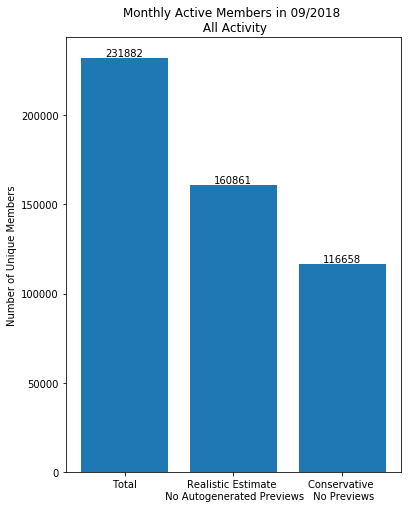

In [63]:
fig1, ax1 = plt.subplots()
bars = ax1.bar(x=[0, 1, 2], height=[num_members_allactivity, num_members_noautogen, num_members_nopreviews])
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Total', 'Realistic Estimate \n No Autogenerated Previews', 'Conservative \n No Previews'])
for rect in bars:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')
ax1.set_ylabel('Number of Unique Members')
ax1.set_title('Monthly Active Members in 09/2018 \n All Activity');

In [64]:
fig1.savefig('mam_estimates.png', bbox_inches='tight', dpi=1000);